In [ ]:
!pip install uszipcode

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import matplotlib.cm as cm

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**To access the data from the Colab notebook, add "SNA" folder as a short-cut folder to your drive at "/content/drive/MyDrive/"**

# 1. Prepare the data

In [ ]:
# import 2019 June data
df19 = pd.read_csv('/content/drive/MyDrive/SNA/data/201906-divvy-tripdata.csv')

# for 2019 data, filter out trips that starts or ends with station id == 360 (maintainance)
df1 = df19[df19['02 - Rental End Station ID']!=360]



# import 2020 June data
df20 = pd.read_csv('/content/drive/MyDrive/SNA/data/202006-divvy-tripdata.csv')

# for 2020 June data, filter out trips with null starting and ending coordinates
df2 = df20[df20['start_lat'].notnull() & df20['end_lat'].notnull()] # from 343005 to 342537 trips

In [ ]:
df1['date'] = df1['01 - Rental Details Local Start Time'].apply(lambda x: x[5:10])
df2['date'] = df2['started_at'].apply(lambda x: x[5:10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


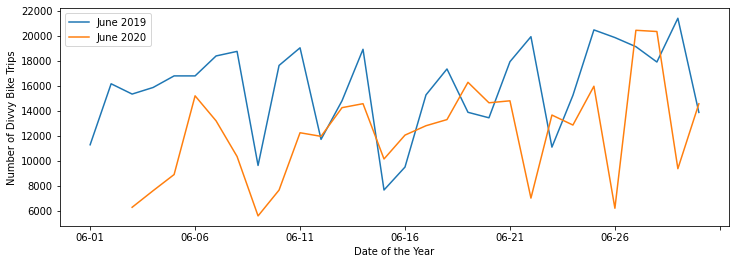

In [ ]:
s1 = df1['date'].value_counts().sort_index()
s2 = df2['date'].value_counts().sort_index()
combined = pd.DataFrame(s1).merge(pd.DataFrame(s2), how='left', left_index=True, right_index=True)
combined.columns = ['June 2019', 'June 2020']
combined.plot.line(figsize=(12,4))
plt.xlabel('Date of the Year')
plt.ylabel('Number of Divvy Bike Trips')
plt.savefig('/content/drive/MyDrive/SNA/figures/trip_number.png', dpi=150, bbox_inches='tight')

In [ ]:
print(df1.shape[0])
print(df2.shape[0])

475374
342537


# 1a. Check station overlap

The 2019 June data did not have coordinates. To identify the zip code of the start and end stations of trips in 2019, we need to use the "station id - zipcode" match from June 2020 data. As a first step, it is important to identify those stations used in 2019 but were not used (as starting station) in 2020.

In [ ]:
# get station level data for df1
stations1_start = df1.groupby('03 - Rental Start Station ID').agg({'03 - Rental Start Station Name': 'first'})
stations1_end = df1.groupby('02 - Rental End Station ID').agg({'02 - Rental End Station Name': 'first'})


# get station level data for df2
stations2_start = df2.groupby('start_station_id').agg({'start_station_name': 'first', 'start_lat':'first',	'start_lng': 'first'})
stations2_end = df2.groupby('end_station_id').agg({'end_station_name':'first'})

In [ ]:
# how many stations in 2019 June data and end stations for June 2020
# were not used as start station in June 2020?
check = {}
for i in stations1_start.index:
  if i not in stations2_start.index and i not in check:
    check[i] = stations1_start.loc[i, '03 - Rental Start Station Name']
for i in stations1_end.index:
  if i not in stations2_start.index and i not in check:
    check[i] = stations1_end.loc[i, '02 - Rental End Station Name']

for i in stations2_end.index:
  if i not in stations2_start.index and i not in check:
    check[i] = stations2_end.loc[i, 'end_station_name']


print(check)
#only three stations used in June 2019 and June 2020(end) were not used as start stations in 2020

{647: 'Elizabeth St & 59th St', 669: 'LBS - BBB La Magie', 674.0: 'Michigan Ave & 71st St'}


## 1b. add zip code to stations2



In [ ]:
from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


In [ ]:
stations2_start['zipcode'] = np.nan
for i in stations2_start.index:
  result = search.by_coordinates(stations2_start.loc[i, 'start_lat'],stations2_start.loc[i, 'start_lng'], radius=5, returns=1)
  stations2_start.loc[i, 'zipcode'] = str(result[0].zipcode)

In [ ]:
#convert the station id - zipcode match to a dictionary
id2zip = stations2_start['zipcode'].to_dict()

# add the three stations
id2zip[647] = '60636' # Elizabeth St & 59th St
id2zip[669] = '60611' # LBS - BBB La Magie
id2zip[674] = '60619' # Michigan Ave & 71st St

In [ ]:
#add the start and end zip code to the 2019 and 2020 trip data

df1['start_zip'] = df1['03 - Rental Start Station ID'].map(id2zip)
df1['end_zip'] = df1['02 - Rental End Station ID'].map(id2zip)

df2['start_zip'] = df2['start_station_id'].map(id2zip)
df2['end_zip'] = df2['end_station_id'].map(id2zip)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
# only keep trips that cross zip code
df1d = df1[df1['start_zip'] != df1['end_zip']]
df2d = df2[df2['start_zip'] != df2['end_zip']]

# calculate the percentage of trips that cross zip code
rate19 = round(100*df1d.shape[0]/df1.shape[0], 1)
rate20 = round(100*df2d.shape[0]/df2.shape[0], 1)

print(f'In June 2019, {rate19}% of trips ({df1d.shape[0]} out of {df1.shape[0]}) crossed zip code boundaries')
print(f'In June 2020, {rate20}% of trips ({df2d.shape[0]} out of {df2.shape[0]}) crossed zip code boundaries')

In June 2019, 74.8% of trips (355797 out of 475374) crossed zip code boundaries
In June 2020, 68.3% of trips (234067 out of 342537) crossed zip code boundaries


In [ ]:
print(len(set(df1['start_zip'])))
print(len(set(df2['start_zip'])))

46
46


# 2. Generate and Graph the networks

In [ ]:
# create a dictionary from zipcode to coordinates
zips = stations2_start['zipcode'].unique()

zip2coord = {}
for i in zips:
  zip = search.by_zipcode(i)
  zip2coord[i] = (zip.lat, zip.lng)

In [ ]:
trips1 = []
for i in df1d.index:
  trips1.append(tuple([df1d.loc[i, 'start_zip'], df1d.loc[i, 'end_zip']]))
trips1 = pd.Series(trips1)
trip_counts1 = trips1.value_counts()

In [ ]:
trips2 = []
for i in df2d.index:
  trips2.append(tuple([df2d.loc[i, 'start_zip'], df2d.loc[i, 'end_zip']]))
trips2 = pd.Series(trips2)
trip_counts2 = trips2.value_counts()

In [ ]:
edge_weights1 = []
for i in range(len(trip_counts1)):
  edge_weights1.append(tuple([trip_counts1.index[i][0], trip_counts1.index[i][1],
                             trip_counts1[i]]))

In [ ]:
edge_weights2 = []
for i in range(len(trip_counts2)):
  edge_weights2.append(tuple([trip_counts2.index[i][0], trip_counts2.index[i][1],
                             trip_counts2[i]]))

In [ ]:
from geopy import distance

In [ ]:
# updated edges for June 2019
edge_weights3 = []
for i in edge_weights1:
  zip1 = i[0]
  zip2 = i[1]
  old_w = i[2]
  dist = distance.distance(zip2coord[zip1], zip2coord[zip2]).miles
  new_w = old_w * dist*10000/df1.shape[0]
  out = tuple([zip1, zip2, new_w])
  edge_weights3.append(out)

In [ ]:
# updated edges for June 2020
edge_weights4 = []
for i in edge_weights2:
  zip1 = i[0]
  zip2 = i[1]
  old_w = i[2]
  dist = distance.distance(zip2coord[zip1], zip2coord[zip2]).miles
  new_w = old_w * dist*10000/df2.shape[0]
  out = tuple([zip1, zip2, new_w])
  edge_weights4.append(out)

In [ ]:
DG1 = nx.DiGraph()
DG1.add_weighted_edges_from(edge_weights1)
G1 = nx.Graph(DG1)

In [ ]:
DG2 = nx.DiGraph()
DG2.add_weighted_edges_from(edge_weights2)
G2 = nx.Graph(DG2)

In [ ]:
DG3 = nx.DiGraph()
DG3.add_weighted_edges_from(edge_weights3)
G3 = nx.Graph(DG3)

In [ ]:
DG4 = nx.DiGraph()
DG4.add_weighted_edges_from(edge_weights4)
G4 = nx.Graph(DG4)

In [ ]:
# only keep central nodes
G5 = G1.copy()
G6 = G2.copy()
G7 = G3.copy()
G8 = G4.copy()

In [ ]:
# drop nodes with degree <= 29
periphery_nodes = ['60645', '60202', '60609', '60653', '60659', '60649', '60203', '60621', '60623',
                   '60624', '60632', '60302', '60644', '60619', '60617', '60636','60651']
G5.remove_nodes_from(periphery_nodes)
G6.remove_nodes_from(periphery_nodes)
G7.remove_nodes_from(periphery_nodes)
G8.remove_nodes_from(periphery_nodes)

In [ ]:
pos = {}
for i in range(len(G1.nodes)):
  coord = zip2coord[list(G1.nodes)[i]]
  pos[list(G1.nodes)[i]] = (float(coord[1]), float(coord[0]))
nx.set_node_attributes(G1, pos, 'coord')

In [ ]:
edge_weights1g = [G1[u][v]['weight']/200 for u,v in G1.edges]
edge_weights2g = [G2[u][v]['weight']/200 for u,v in G2.edges]

In [ ]:
edge_weights3g = [G3[u][v]['weight']/30 for u,v in G3.edges]
edge_weights4g = [G4[u][v]['weight']/30 for u,v in G4.edges]

In [ ]:
def draw_graph(G, w, title_name, file_name):
  plt.subplots(figsize=(8, 10))
  nx.draw_networkx_nodes(G, pos, node_size = 200, node_color='#3DB7E4', node_shape="o", alpha=0.7)
  nx.draw_networkx_edges(G, pos, width = w, edge_color='#52464A', alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=10)
  plt.title(f'Cross Zipcode Divvy Bike Trip Network by Zipcode ({title_name})')
  plt.savefig(f'/content/drive/MyDrive/SNA/figures/divvy{file_name}.png', dpi=150, bbox_inches='tight')

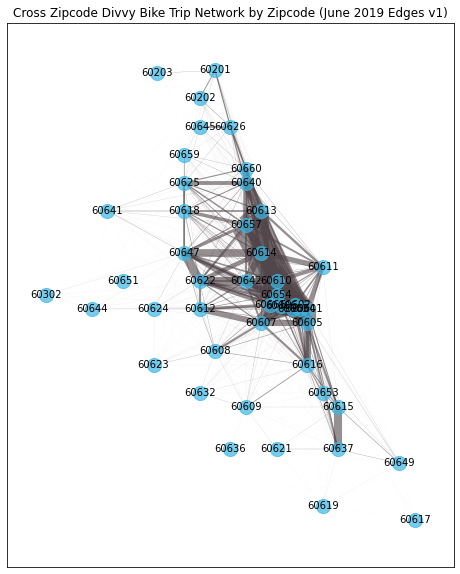

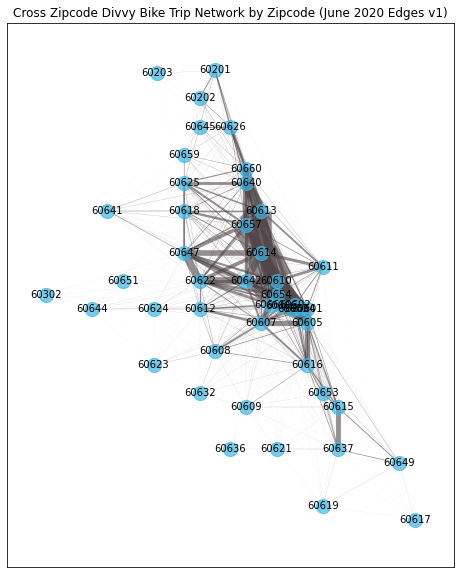

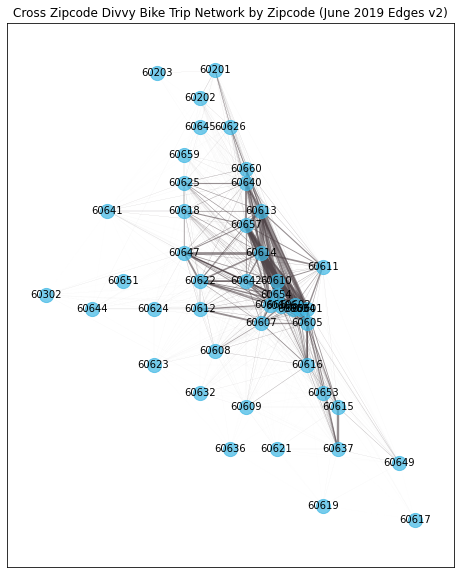

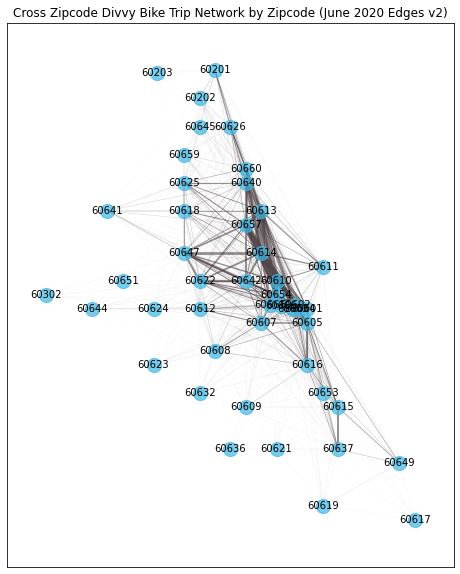

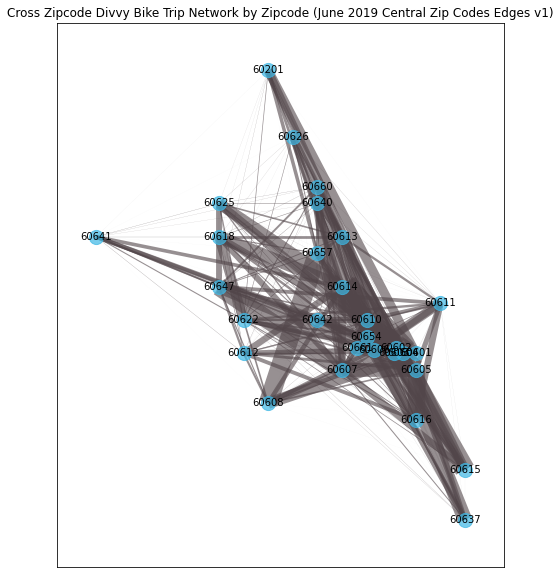

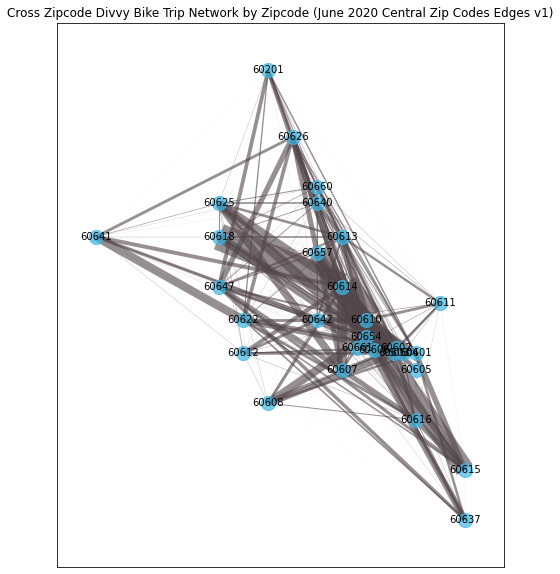

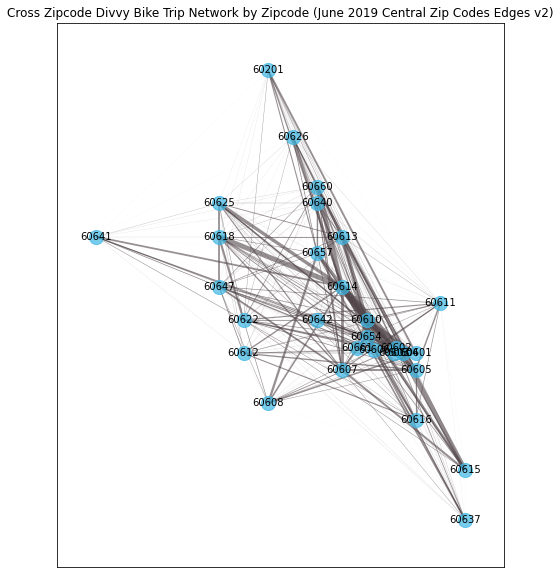

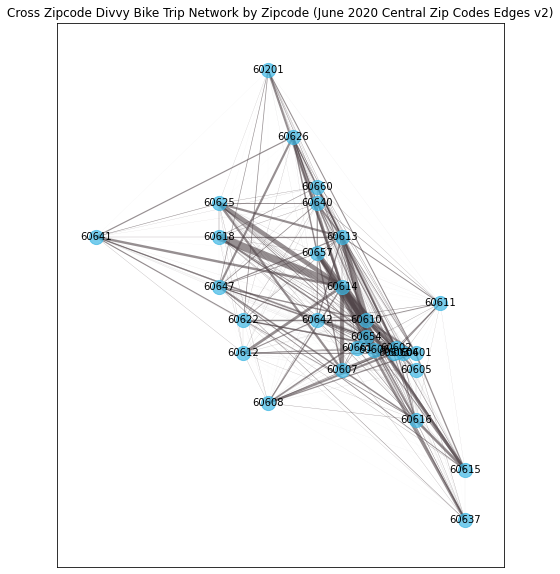

In [ ]:
draw_graph(G1, edge_weights1g, 'June 2019 Edges v1', '2019a')
draw_graph(G2, edge_weights2g, 'June 2020 Edges v1', '2020a')
draw_graph(G3, edge_weights3g, 'June 2019 Edges v2', '2019b')
draw_graph(G4, edge_weights4g, 'June 2020 Edges v2', '2020b')
draw_graph(G5, edge_weights1g, 'June 2019 Central Zip Codes Edges v1', '2019c')
draw_graph(G6, edge_weights2g, 'June 2020 Central Zip Codes Edges v1', '2020c')
draw_graph(G7, edge_weights3g, 'June 2019 Central Zip Codes Edges v2', '2019d')
draw_graph(G8, edge_weights4g, 'June 2020 Central Zip Codes Edges v2', '2020d')

# 3. Analyze the networks 

### Clustering Coefficients

In [ ]:
print(nx.average_clustering(G1, weight='edge_weights1'))
print(nx.average_clustering(G2, weight='edge_weights2'))

0.8239216619061643
0.8378548455177792


In [ ]:
print(nx.average_clustering(G3, weight='edge_weights3'))
print(nx.average_clustering(G4, weight='edge_weights4'))

0.8239216619061643
0.8378548455177792


In [ ]:
print(nx.average_clustering(G5, weight='edge_weights1'))
print(nx.average_clustering(G6, weight='edge_weights2'))

0.9578573916504953
0.9609655118050919


In [ ]:
print(nx.average_clustering(G7, weight='edge_weights3'))
print(nx.average_clustering(G8, weight='edge_weights4'))

0.9578573916504953
0.9609655118050919


### Clauset-Newman-Moore Greedy Modularity

In [ ]:
#from networkx.algorithms import community
import networkx as nx
import networkx.algorithms.community as nxcom

In [ ]:
C1 = sorted(nxcom.greedy_modularity_communities(G1, weight='edge_weights1'), key=min, reverse=True)
C2 = sorted(nxcom.greedy_modularity_communities(G2, weight='edge_weights2'), key=min, reverse=True)
C3 = sorted(nxcom.greedy_modularity_communities(G3, weight='edge_weights3'), key=min, reverse=True)
C4 = sorted(nxcom.greedy_modularity_communities(G4, weight='edge_weights4'), key=min, reverse=True)
C5 = sorted(nxcom.greedy_modularity_communities(G5, weight='edge_weights1'), key=min, reverse=True)
C6 = sorted(nxcom.greedy_modularity_communities(G6, weight='edge_weights2'), key=min, reverse=True)
C7 = sorted(nxcom.greedy_modularity_communities(G7, weight='edge_weights3'), key=min, reverse=True)
C8 = sorted(nxcom.greedy_modularity_communities(G8, weight='edge_weights4'), key=min, reverse=True)

In [ ]:
def set_node_community(G, communities):
  '''Add community to node attributes'''
  for c, v_c in enumerate(communities):
    for v in v_c:
      G.nodes[v]['community'] = c + 1

def set_edge_community(G):
  for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
      G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
      G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
  '''Assign a color to a vertex.'''
  r0, g0, b0 = 0, 0, 0
  n = 16
  low, high = 0.1, 0.9
  span = high - low
  r = low + span * (((i + r_off) * 3) % n) / (n - 1)
  g = low + span * (((i + g_off) * 5) % n) / (n - 1)
  b = low + span * (((i + b_off) * 7) % n) / (n - 1)
  return (r, g, b)            

In [ ]:
def draw_communities(G, C, ww, title_name, file_name): 
  set_node_community(G, C)
  set_edge_community(G)
  node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

  external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
  internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
  internal_color = ['black' for e in internal]
  plt.subplots(figsize=(8, 10))
  nx.draw_networkx_nodes(G, pos, node_size= 200, node_color=node_color, node_shape="o", alpha=0.7)
  nx.draw_networkx_edges(G, pos, width = ww, edge_color='#52464A', alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=10)
  plt.title(f'Cross Zipcode Divvy Bike Trip Network Community Detection ({title_name})')
  plt.savefig(f'/content/drive/MyDrive/SNA/figures/community{file_name}.png', dpi=150, bbox_inches='tight')

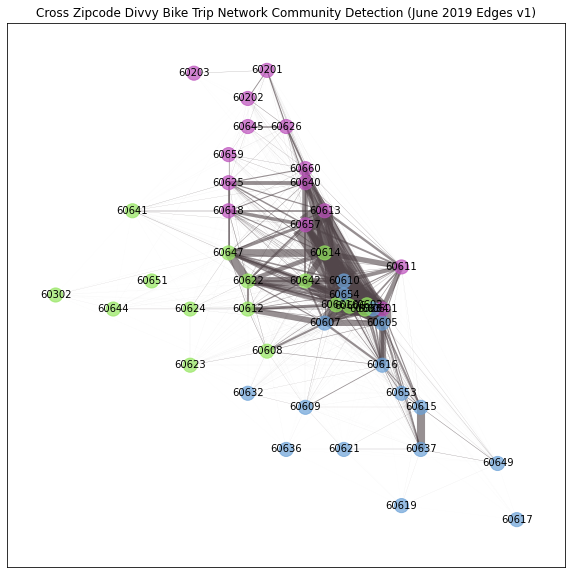

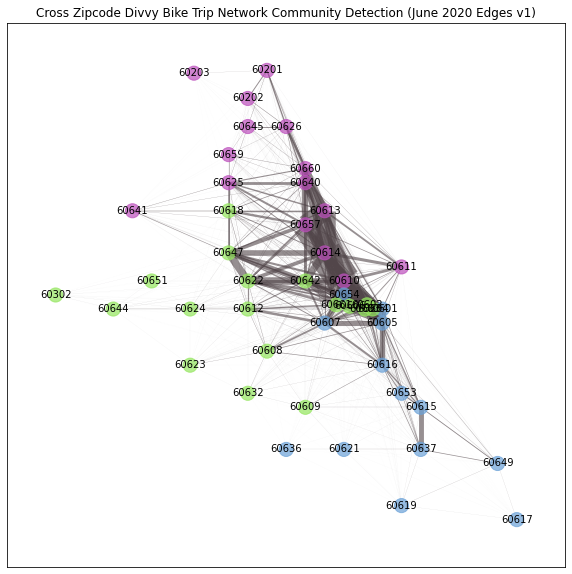

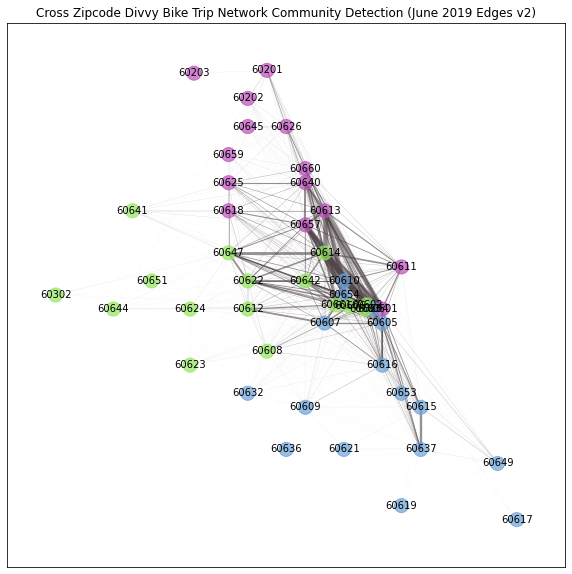

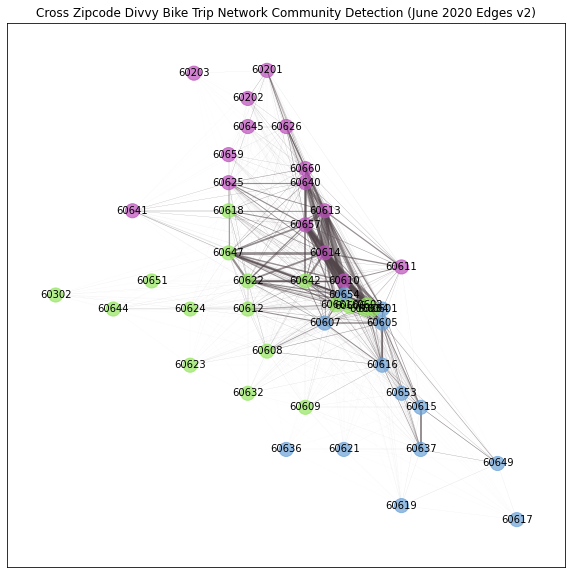

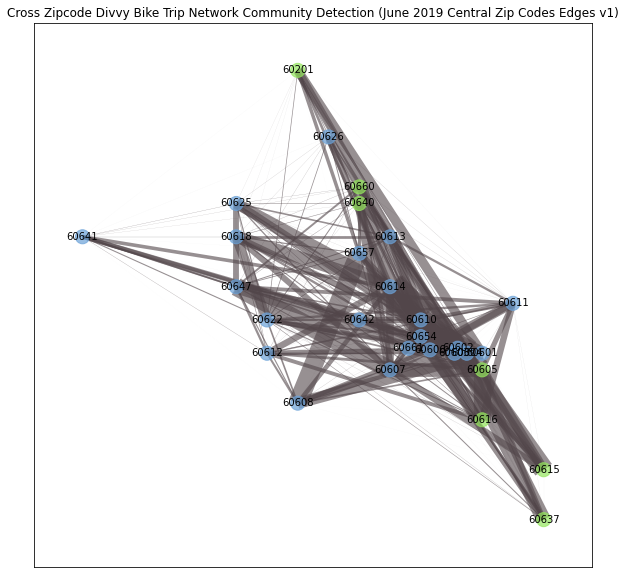

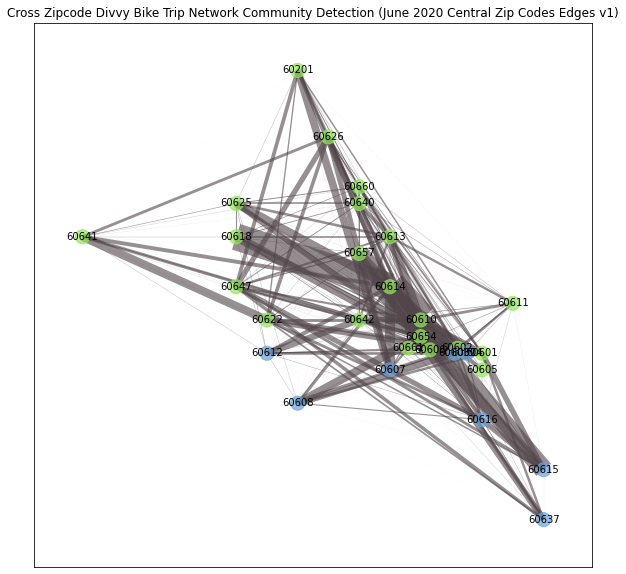

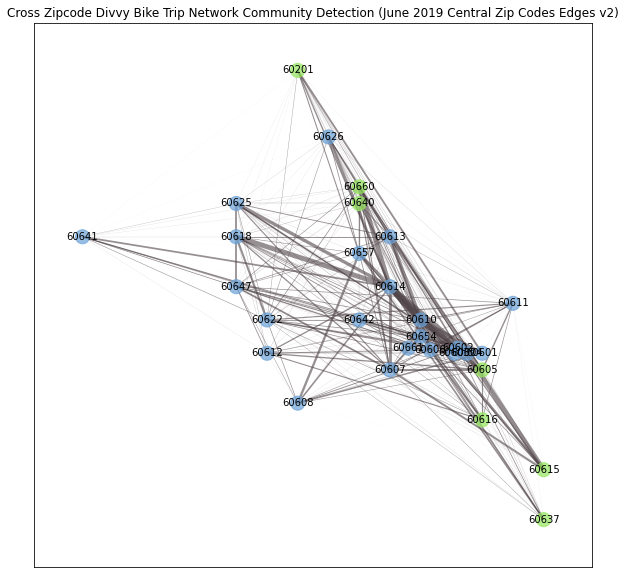

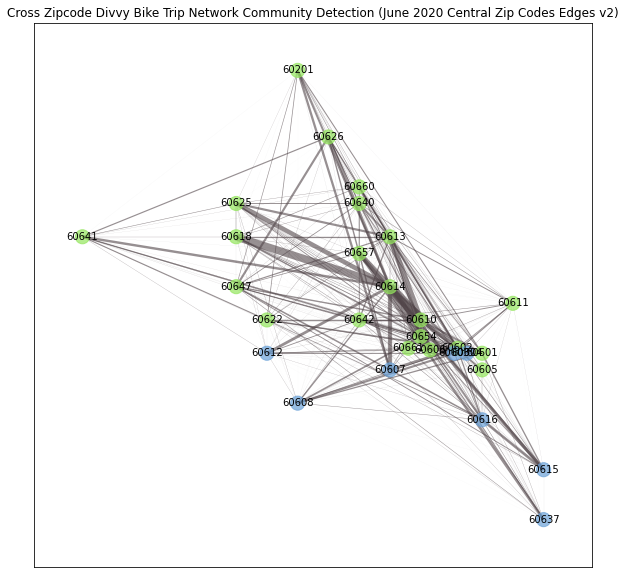

In [ ]:
draw_communities(G1, C1, edge_weights1g, 'June 2019 Edges v1', '2019a')
draw_communities(G2, C2, edge_weights2g, 'June 2020 Edges v1', '2020a')
draw_communities(G3, C3, edge_weights3g, 'June 2019 Edges v2', '2019b')
draw_communities(G4, C4, edge_weights4g, 'June 2020 Edges v2', '2020b')
draw_communities(G5, C5, edge_weights1g, 'June 2019 Central Zip Codes Edges v1', '2019c')
draw_communities(G6, C6, edge_weights2g, 'June 2020 Central Zip Codes Edges v1', '2020c')
draw_communities(G7, C7, edge_weights3g, 'June 2019 Central Zip Codes Edges v2', '2019d')
draw_communities(G8, C8, edge_weights4g, 'June 2020 Central Zip Codes Edges v2', '2020d')

### Louvain

In [ ]:
from community import community_louvain

In [ ]:
def set_node_louvain(G, communities):
  '''Add community to node attributes'''
  for v in G.nodes:
      G.nodes[v]['community'] = communities[v]       

def get_color_louvain(i, communities):
  '''Assign a color to a vertex.
     Use 3 corner nodes as benchmark
  '''
  # same color as in get_color, ensure consistency in color
  green = (0.5800000000000001, 0.9, 0.3666666666666667)
  pink = (0.7400000000000001, 0.31333333333333335, 0.7400000000000001)
  blue = (0.42000000000000004, 0.6333333333333333, 0.8466666666666667)

  # three corner nodes: 60637, 60612, 60201
  cmap = {communities['60637']: green,
          communities['60612']: blue,
          communities['60201']: pink} 

  return cmap[i]

In [ ]:
def draw_louvain(G, C, ww, title_name, file_name, small=False): 
  set_node_louvain(G, C)
  set_edge_community(G)

  if small:
      node_color = [get_color(G.nodes[v]['community'] + 1) for v in G.nodes]
  else:
      node_color = [get_color_louvain(G.nodes[v]['community'], C) for v in G.nodes]

  external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
  internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
  internal_color = ['black' for e in internal]
  plt.subplots(figsize=(8, 10))
  nx.draw_networkx_nodes(G, pos, node_size= 200, node_color=node_color, node_shape="o", alpha=0.7)
  nx.draw_networkx_edges(G, pos, width = ww, edge_color='#52464A', alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=10)
  plt.title(f'Cross Zipcode Divvy Bike Trip Network (Louvain) ({title_name})')
  plt.savefig(f'/content/drive/MyDrive/SNA/figures/louvain{file_name}.png', dpi=150, bbox_inches='tight')

In [ ]:
L1 = community_louvain.best_partition(G1, weight='edge_weights1', random_state=17)
L2 = community_louvain.best_partition(G2, weight='edge_weights2', random_state=17)
L3 = community_louvain.best_partition(G3, weight='edge_weights3', random_state=17)
L4 = community_louvain.best_partition(G4, weight='edge_weights4', random_state=17)
L5 = community_louvain.best_partition(G5, weight='edge_weights1', random_state=17)
L6 = community_louvain.best_partition(G6, weight='edge_weights2', random_state=17)
L7 = community_louvain.best_partition(G7, weight='edge_weights3', random_state=17)
L8 = community_louvain.best_partition(G8, weight='edge_weights4', random_state=17)

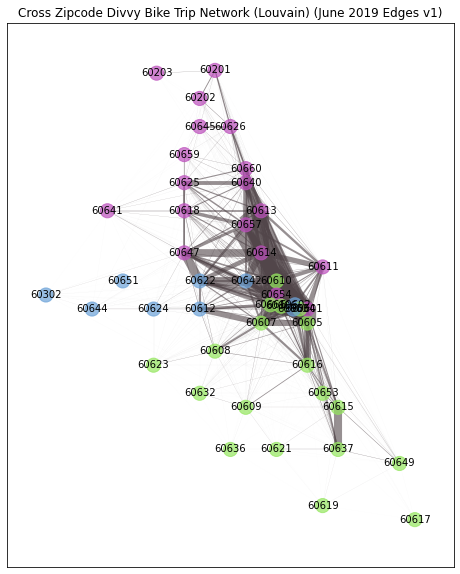

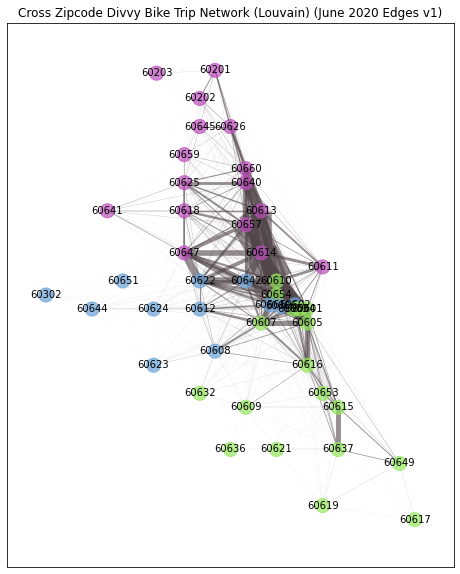

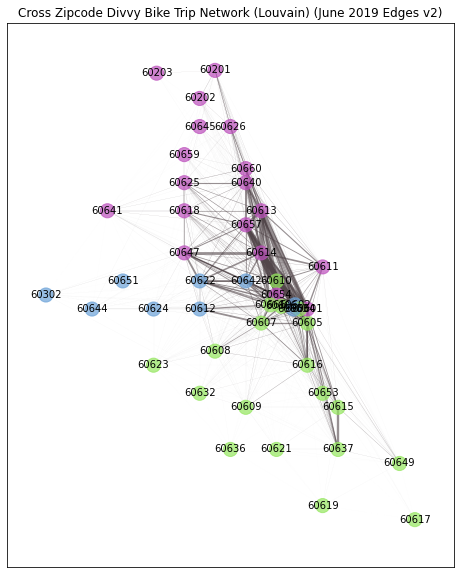

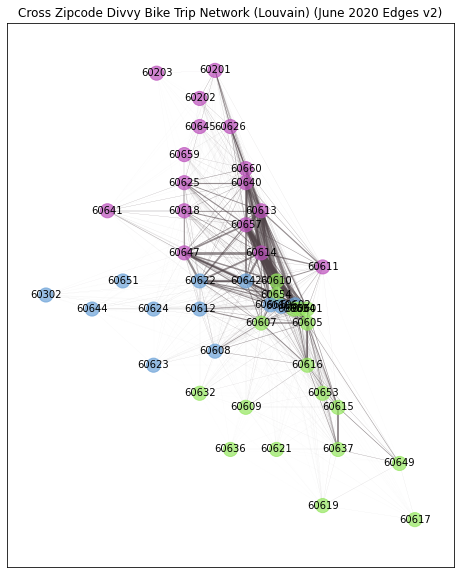

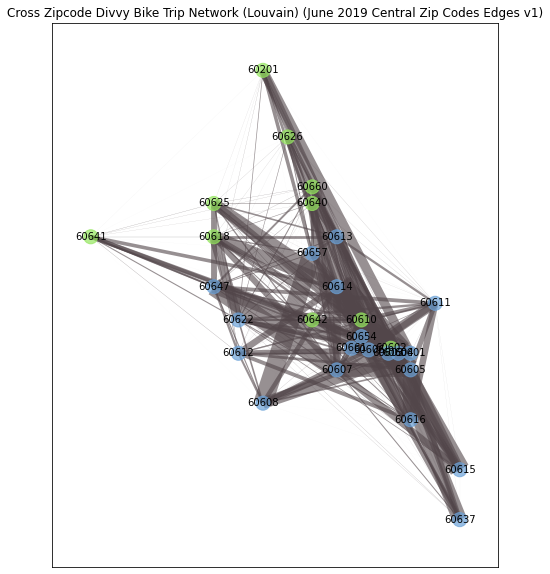

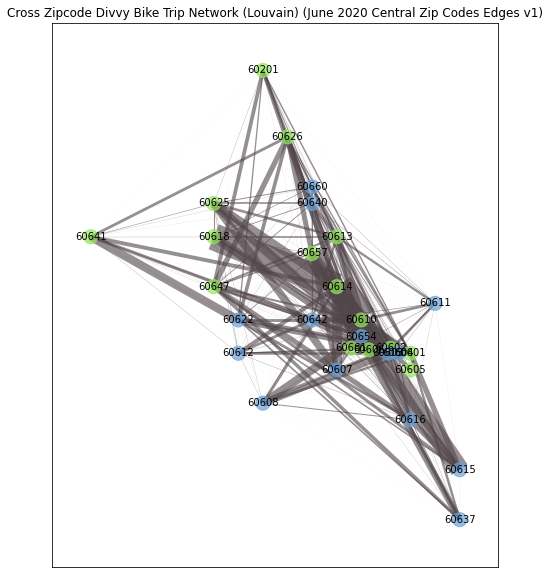

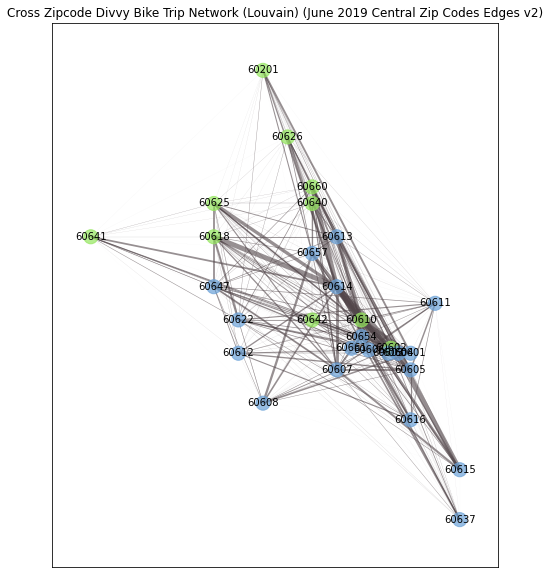

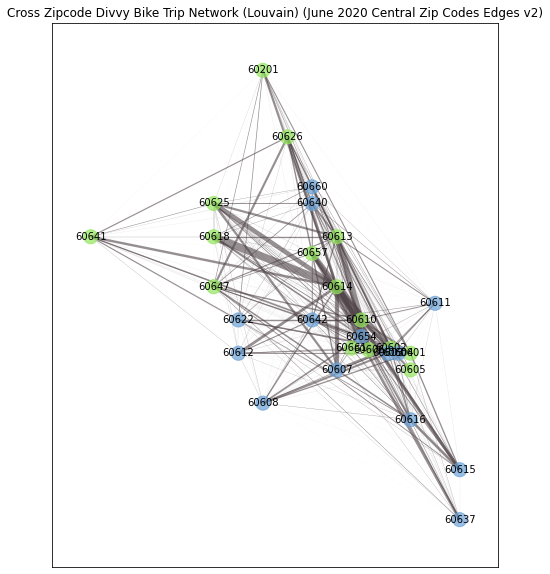

In [ ]:
draw_louvain(G1, L1, edge_weights1g, 'June 2019 Edges v1', '2019a')
draw_louvain(G2, L2, edge_weights2g, 'June 2020 Edges v1', '2020a')
draw_louvain(G3, L3, edge_weights3g, 'June 2019 Edges v2', '2019b')
draw_louvain(G4, L4, edge_weights4g, 'June 2020 Edges v2', '2020b')
draw_louvain(G5, L5, edge_weights1g, 'June 2019 Central Zip Codes Edges v1', '2019c', True)
draw_louvain(G6, L6, edge_weights2g, 'June 2020 Central Zip Codes Edges v1', '2020c', True)
draw_louvain(G7, L7, edge_weights3g, 'June 2019 Central Zip Codes Edges v2', '2019d', True)
draw_louvain(G8, L8, edge_weights4g, 'June 2020 Central Zip Codes Edges v2', '2020d', True)

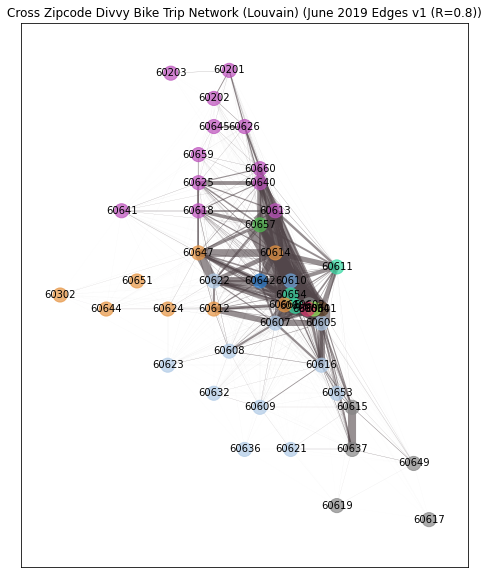

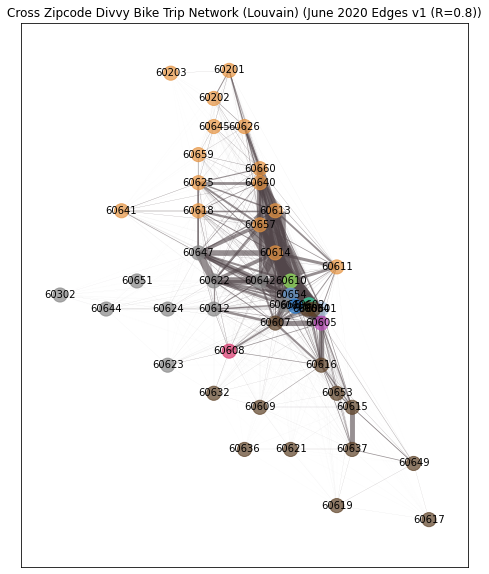

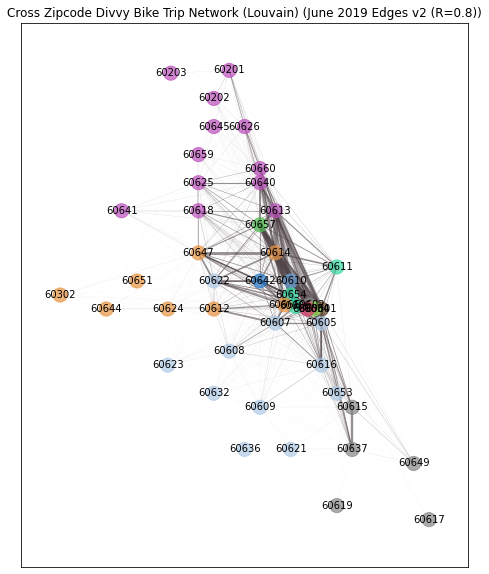

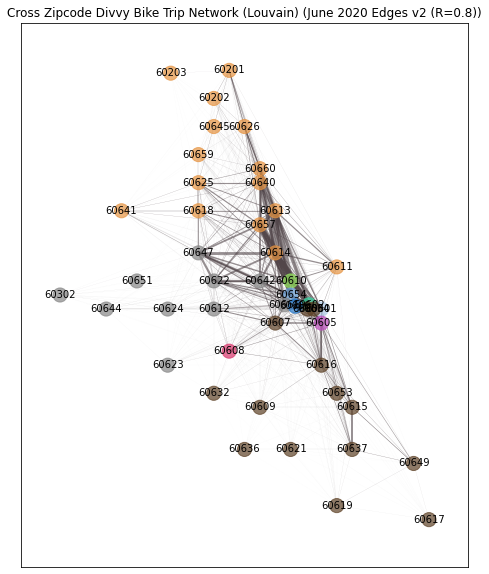

In [ ]:
res = 0.8
rs = 17
LR1 = community_louvain.best_partition(G1, weight='edge_weights1', random_state=rs, resolution=res)
LR2 = community_louvain.best_partition(G2, weight='edge_weights2', random_state=rs, resolution=res)
LR3 = community_louvain.best_partition(G3, weight='edge_weights3', random_state=rs, resolution=res)
LR4 = community_louvain.best_partition(G4, weight='edge_weights4', random_state=rs, resolution=res)
draw_louvain(G1, LR1, edge_weights1g, 'June 2019 Edges v1 (R=%s)' % str(res), '2019a_r2', True)
draw_louvain(G2, LR2, edge_weights2g, 'June 2020 Edges v1 (R=%s)' % str(res), '2020a_r2', True)
draw_louvain(G3, LR3, edge_weights3g, 'June 2019 Edges v2 (R=%s)' % str(res), '2019b_r2', True)
draw_louvain(G4, LR4, edge_weights4g, 'June 2020 Edges v2 (R=%s)' % str(res), '2020b_r2', True)

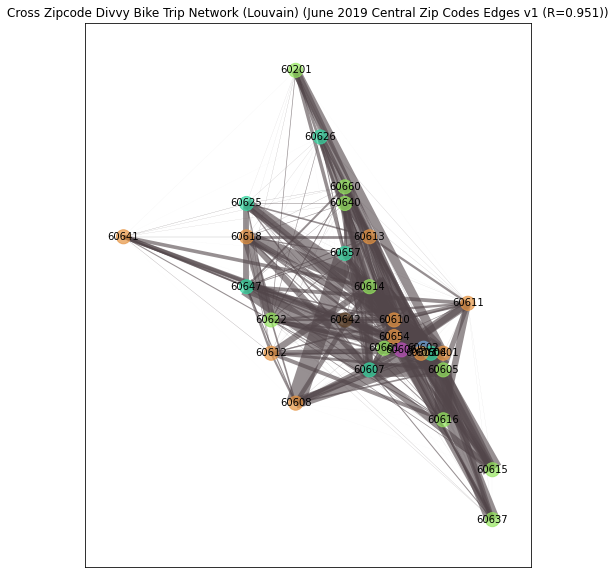

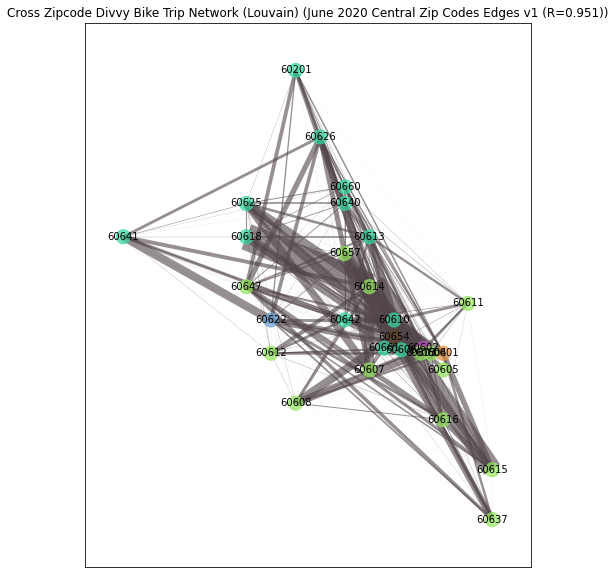

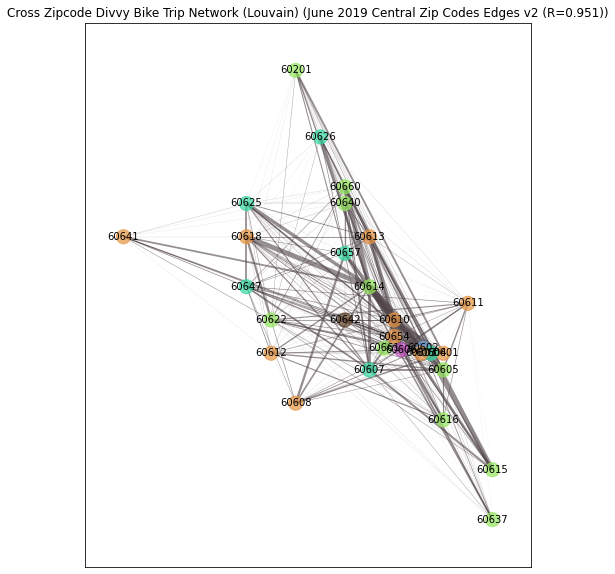

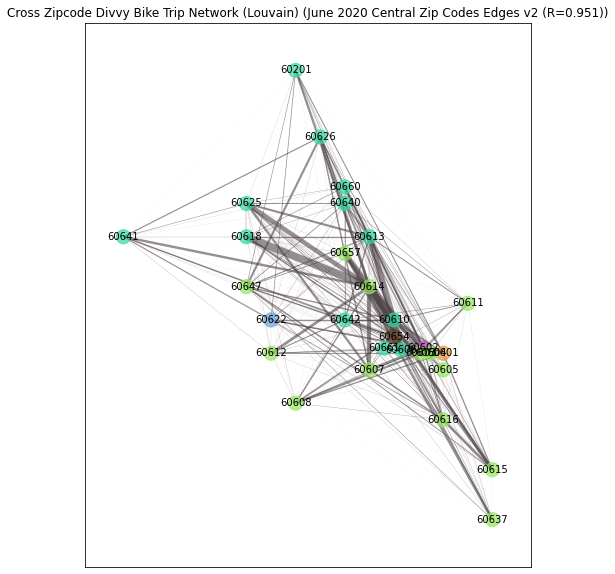

In [ ]:
res = 0.951
rs = 18
LR5 = community_louvain.best_partition(G5, weight='edge_weights1', random_state=rs, resolution=res)
LR6 = community_louvain.best_partition(G6, weight='edge_weights2', random_state=rs, resolution=res)
LR7 = community_louvain.best_partition(G7, weight='edge_weights3', random_state=rs, resolution=res)
LR8 = community_louvain.best_partition(G8, weight='edge_weights4', random_state=rs, resolution=res)
draw_louvain(G5, LR5, edge_weights1g, 'June 2019 Central Zip Codes Edges v1 (R=%s)' % str(res), '2019c_r2', True)
draw_louvain(G6, LR6, edge_weights2g, 'June 2020 Central Zip Codes Edges v1 (R=%s)' % str(res), '2020c_r2', True)
draw_louvain(G7, LR7, edge_weights3g, 'June 2019 Central Zip Codes Edges v2 (R=%s)' % str(res), '2019d_r2', True)
draw_louvain(G8, LR8, edge_weights4g, 'June 2020 Central Zip Codes Edges v2 (R=%s)' % str(res), '2020d_r2', True)

### Girvan-Newman

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman
import itertools

In [ ]:
comp = girvan_newman(G1)
for communities in itertools.islice(comp, 6):
    print(tuple(sorted(c) for c in communities))

(['60201', '60202', '60203', '60302', '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616', '60617', '60618', '60619', '60621', '60622', '60623', '60624', '60625', '60626', '60632', '60636', '60637', '60640', '60641', '60642', '60644', '60645', '60647', '60649', '60653', '60654', '60657', '60659', '60660', '60661'], ['60651'])
(['60201', '60202', '60302', '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616', '60617', '60618', '60619', '60621', '60622', '60623', '60624', '60625', '60626', '60632', '60636', '60637', '60640', '60641', '60642', '60644', '60645', '60647', '60649', '60653', '60654', '60657', '60659', '60660', '60661'], ['60203'], ['60651'])
(['60201', '60202', '60302', '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613', '60614', '6061

### Comparison of Modularity

In [ ]:
from collections import defaultdict

def louvain_partition(communities):
    ''' Convert Louvain Communities (dict) into list of sets to calculate modularity
    '''
    d = defaultdict(set)
    for k, v in communities.items():
        d[v].add(k)
    
    partition_lst = []
    for k, v in d.items():
        partition_lst.append(v)
    
    return partition_lst

In [ ]:
# 2019, edge weight = number of trips
print('2019, edgeweight1: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G1, C1))
print('Modularity (Louvain): ', nxcom.modularity(G1, louvain_partition(L1)))
# 2020, edge weight = number of trips
print('2020, edgeweight1: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G2, C2))
print('Modularity (Louvain): ', nxcom.modularity(G2, louvain_partition(L2)))
# 2019, edge weight = number of trips * distance / total trip
print('2019, edgeweight2: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G3, C3))
print('Modularity (Louvain): ', nxcom.modularity(G3, louvain_partition(L3)))
# 2020, edge weight = number of trips * distance / total trip
print('2020, edgeweight2: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G4, C4))
print('Modularity (Louvain): ', nxcom.modularity(G4, louvain_partition(L4)))
# 2019, edge weight = number of trips
print('2019, edgeweight1, central only: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G5, C5))
print('Modularity (Louvain): ', nxcom.modularity(G5, louvain_partition(L5)))
# 2020, edge weight = number of trips
print('2020, edgeweight1, central only: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G6, C6))
print('Modularity (Louvain): ', nxcom.modularity(G6, louvain_partition(L6)))
# 2019, edge weight = number of trips * distance / total trip
print('2019, edgeweight2, central only: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G7, C7))
print('Modularity (Louvain): ', nxcom.modularity(G7, louvain_partition(L7)))
# 2020, edge weight = number of trips * distance / total trip
print('2020, edgeweight2, central only: ')
print('Modularity (Clauset-Newman-Moore): ', nxcom.modularity(G8, C8))
print('Modularity (Louvain): ', nxcom.modularity(G8, louvain_partition(L8)))

2019, edgeweight1: 
Modularity (Clauset-Newman-Moore):  0.06831563395292795
Modularity (Louvain):  0.07289261577251244
2020, edgeweight1: 
Modularity (Clauset-Newman-Moore):  0.17061622758134684
Modularity (Louvain):  0.16254514292050232
2019, edgeweight2: 
Modularity (Clauset-Newman-Moore):  0.07967047529560657
Modularity (Louvain):  0.08698305521832882
2020, edgeweight2: 
Modularity (Clauset-Newman-Moore):  0.14299518921438886
Modularity (Louvain):  0.10797839741766133
2019, edgeweight1, central only: 
Modularity (Clauset-Newman-Moore):  0.03525784115713136
Modularity (Louvain):  -0.017699490648143842
2020, edgeweight1, central only: 
Modularity (Clauset-Newman-Moore):  0.04716348425704765
Modularity (Louvain):  0.004904131175606757
2019, edgeweight2, central only: 
Modularity (Clauset-Newman-Moore):  0.03969666799094845
Modularity (Louvain):  -0.004249649045831375
2020, edgeweight2, central only: 
Modularity (Clauset-Newman-Moore):  0.058257994078510865
Modularity (Louvain):  0.0057

### Downtown Chicago

In [ ]:
# only keep central nodes
Gc1 = G1.copy()
Gc2 = G2.copy()
Gc3 = G3.copy()
Gc4 = G4.copy()

In [ ]:
# only interested in Chicago downtown nodes
center_nodes = ['60610', '60654', '60611', '60661', '60606', '60605', '60604', '60603', '60602', '60601']
center_nodes.extend(['60642', '60607', '60616', '60614'])
#center_nodes_extra = center_nodes.extend(['60642', '60607'])

Gc1 = G1.subgraph(center_nodes)
Gc2 = G2.subgraph(center_nodes)
Gc3 = G3.subgraph(center_nodes)
Gc4 = G4.subgraph(center_nodes)

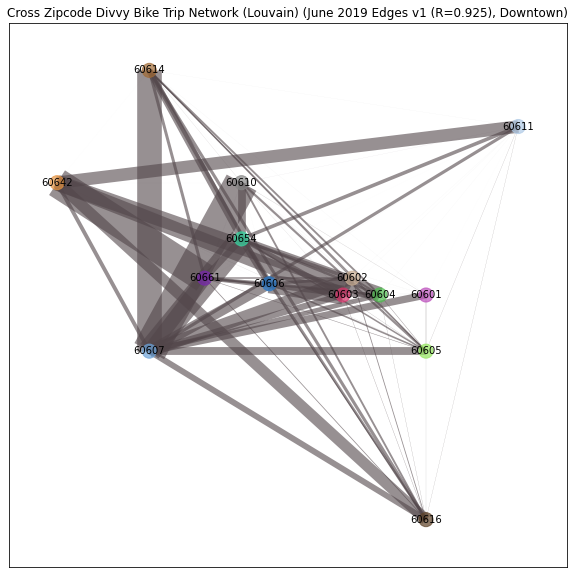

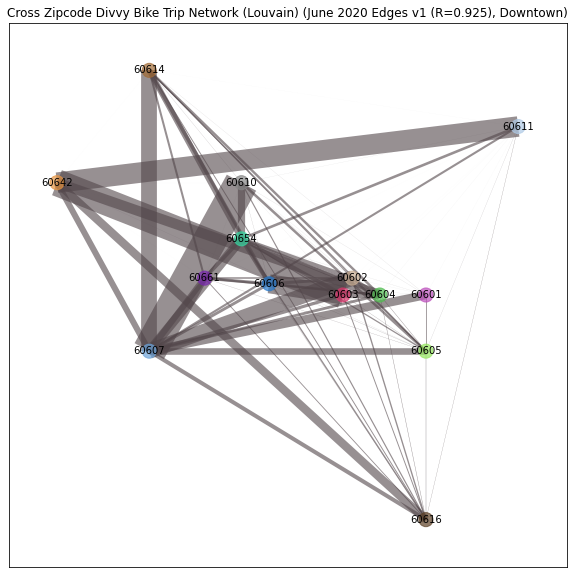

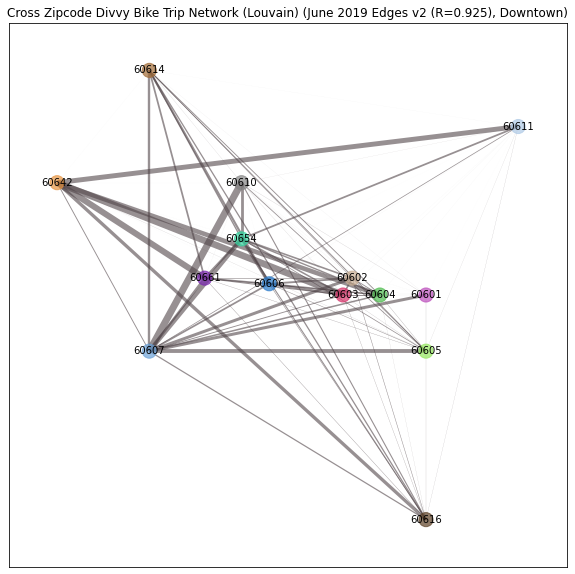

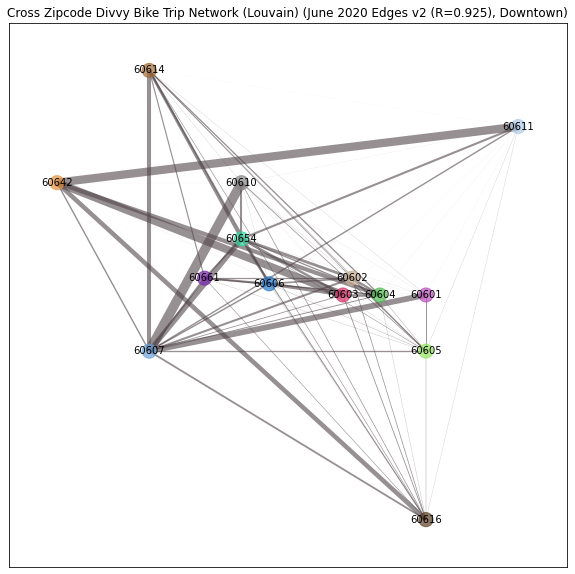

In [ ]:
res = 0.925
rs = 24
SLR1 = community_louvain.best_partition(Gc1, weight='edge_weights1', random_state=rs, resolution=res)
SLR2 = community_louvain.best_partition(Gc2, weight='edge_weights2', random_state=rs, resolution=res)
SLR3 = community_louvain.best_partition(Gc3, weight='edge_weights3', random_state=rs, resolution=res)
SLR4 = community_louvain.best_partition(Gc4, weight='edge_weights4', random_state=rs, resolution=res)

draw_louvain(Gc1, SLR1, edge_weights1g, 'June 2019 Edges v1 (R=%s), Downtown' % str(res), '2019c_r2_dt', True)
draw_louvain(Gc2, SLR2, edge_weights2g, 'June 2020 Edges v1 (R=%s), Downtown' % str(res), '2020c_r2_dt', True)
draw_louvain(Gc3, SLR3, edge_weights3g, 'June 2019 Edges v2 (R=%s), Downtown' % str(res), '2019d_r2_dt', True)
draw_louvain(Gc4, SLR4, edge_weights4g, 'June 2020 Edges v2 (R=%s), Downtown' % str(res), '2020d_r2_dt', True)

In [ ]:
def norm_degree(G):
    '''
    Calculate Normalized Degree for each node
    '''
    degrees = [G.degree(n, weight='weight') for n in G.nodes()]
    degrees = degrees / sum(degrees)

    return degrees

In [ ]:
degree_Gc1 = norm_degree(Gc1)
degree_Gc2 = norm_degree(Gc2)
degree_Gc3 = norm_degree(Gc3)
degree_Gc4 = norm_degree(Gc4)

degree_G1 = norm_degree(G1)
degree_G2 = norm_degree(G2)
degree_G3 = norm_degree(G3)
degree_G4 = norm_degree(G4)

In [ ]:
def plot_degree(d2019, d2020, G, title, down=False):
    '''
    Plot Degree Distribution
    '''
    plot_df = pd.DataFrame(data = {'2019': d2019, '2020': d2020},
                           index = list(G.nodes()))
    
    center_nodes = ['60610', '60654', '60611', '60661', '60606', '60605', '60604', '60603', '60602', '60601']
    center_nodes.extend(['60642', '60607', '60616', '60614'])

    if down:
        plot_df[plot_df.index.isin(center_nodes)].sort_values(by=['2019'], ascending=False).plot(kind='bar', title = title)
    else:
        plot_df.sort_values(by=['2019'], ascending=False).plot(kind='bar', title = title)


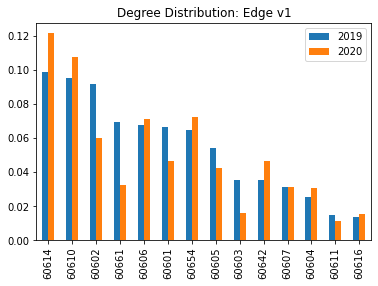

In [ ]:
plot_degree(degree_G1, degree_G2, G1, 'Degree Distribution: Edge v1', True)

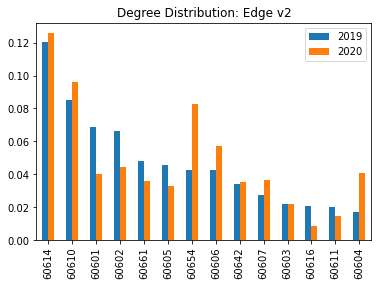

In [ ]:
plot_degree(degree_G3, degree_G4, G3, 'Degree Distribution: Edge v2', True)

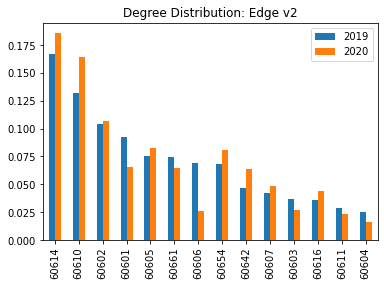

In [ ]:
plot_degree(degree_Gc3, degree_Gc4, Gc3, 'Degree Distribution: Edge v2')

In [ ]:
def plot_degree_change(d2019, d2020, G, title, file_name, down=False):
    '''
    Plot Degree Distribution
    '''
    plot_df = pd.DataFrame(data = {'2019': d2019, '2020': d2020},
                           index = list(G.nodes()))
    plot_df['delta'] = plot_df['2020'] - plot_df['2019']
    
    center_nodes = ['60610', '60654', '60611', '60661', '60606', '60605', '60604', '60603', '60602', '60601']
    center_nodes.extend(['60642', '60607', '60616', '60614'])

    if down:
        plot_df[plot_df.index.isin(center_nodes)]['delta'].sort_values(ascending=False).plot(kind='bar', title = title)
        plt.savefig(f'/content/drive/MyDrive/SNA/figures/degree_del_{file_name}.png', dpi=150, bbox_inches='tight')
    else:
        plot_df['delta'].sort_values(ascending=False).plot(kind='bar', title = title)
        plt.savefig(f'/content/drive/MyDrive/SNA/figures/degree_del_{file_name}.png', dpi=150, bbox_inches='tight')

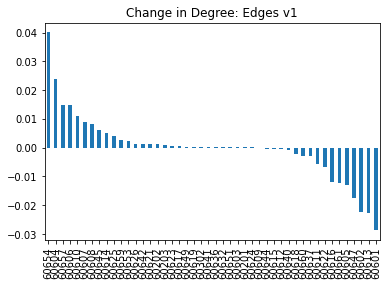

In [ ]:
plot_degree_change(degree_G3, degree_G4, G3, 'Change in Degree: Edges v1', 'edgev1')

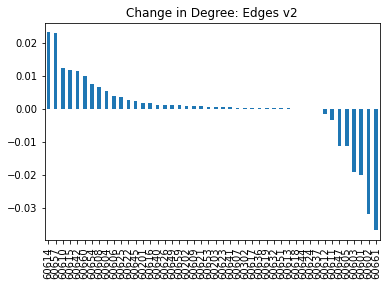

In [ ]:
plot_degree_change(degree_G1, degree_G2, G1, 'Change in Degree: Edges v2', 'edgev2')

In [ ]:
plot_df = pd.DataFrame(data = {'2019': degree_G1, '2020': degree_G2},
                       index = list(G1.nodes()))
plot_df['delta'] = plot_df['2020'] - plot_df['2019']
plot_df.sort_values(by=['delta'])

2019      2020     delta
60661  0.069024  0.032159 -0.036866
60602  0.091704  0.059800 -0.031904
60601  0.066192  0.046198 -0.019993
60603  0.035116  0.015839 -0.019277
60605  0.053732  0.042299 -0.011433
60647  0.021263  0.009869 -0.011394
60611  0.014509  0.011145 -0.003364
60612  0.009621  0.007937 -0.001685
60637  0.007051  0.006962 -0.000089
60624  0.000564  0.000477 -0.000088
60644  0.000219  0.000198 -0.000022
60618  0.008384  0.008439  0.000055
60613  0.046077  0.046138  0.000061
60651  0.000009  0.000112  0.000103
60632  0.000413  0.000520  0.000106
60619  0.000100  0.000210  0.000111
60636  0.000066  0.000189  0.000123
60617  0.000026  0.000236  0.000211
60302  0.000151  0.000395  0.000244
60607  0.030853  0.031145  0.000292
60641  0.000903  0.001263  0.000359
60623  0.000342  0.000709  0.000367
60203  0.000154  0.000580  0.000426
60653  0.001579  0.002177  0.000599
60621  0.000313  0.001039  0.000726
60609  0.001180  0.001963  0.000783
60202  0.001020  0.001915  0.000895
60659  0.001029  0.001997  0.000968
60649  0.000824  0.001898  0.001075
60626  0.004338  0.005446  0.001108
60640  0.021420  0.022612  0.001192
60616  0.013486  0.015074  0.001589
60201  0.001995  0.003646  0.001651
60645  0.001402  0.003646  0.002244
60622  0.025230  0.027735  0.002505
60625  0.007561  0.010973  0.003412
60606  0.067315  0.071198  0.003883
60604  0.025102  0.030381  0.005279
60608  0.003349  0.009981  0.006632
60654  0.064428  0.071980  0.007552
60660  0.011445  0.021220  0.009775
60642  0.035039  0.046525  0.011485
60615  0.008421  0.020043  0.011622
60610  0.095092  0.107578  0.012486
60657  0.053552  0.076626  0.023074
60614  0.098407  0.121528  0.023121

In [ ]:
plot_df = pd.DataFrame(data = {'2019': degree_G3, '2020': degree_G4},
                       index = list(G3.nodes()))
plot_df['delta'] = plot_df['2020'] - plot_df['2019']
#plot_df.sort_values(by=['delta'])
plot_df.sort_index()

2019      2020     delta
60201  0.004297  0.004435  0.000137
60202  0.001428  0.002549  0.001120
60203  0.000214  0.001054  0.000840
60302  0.000470  0.000701  0.000231
60601  0.068604  0.039921 -0.028684
60602  0.066487  0.044192 -0.022295
60603  0.021758  0.021898  0.000141
60604  0.017174  0.040914  0.023740
60605  0.045813  0.032674 -0.013139
60606  0.042335  0.057018  0.014683
60607  0.027508  0.036496  0.008988
60608  0.005281  0.013463  0.008182
60609  0.002223  0.002245  0.000022
60610  0.085157  0.096281  0.011124
60611  0.020168  0.014479 -0.005688
60612  0.012627  0.012057 -0.000570
60613  0.065678  0.042995 -0.022683
60614  0.120655  0.125850  0.005195
60615  0.013909  0.013544 -0.000364
60616  0.020415  0.008318 -0.012097
60617  0.000095  0.000602  0.000507
60618  0.012716  0.010634 -0.002082
60619  0.000201  0.000460  0.000259
60621  0.000481  0.001656  0.001176
60622  0.032379  0.025684 -0.006695
60623  0.000690  0.001271  0.000581
60624  0.000968  0.001078  0.000109
60625  0.011204  0.015358  0.004154
60626  0.006862  0.008170  0.001308
60632  0.000824  0.001020  0.000195
60636  0.000131  0.000342  0.000211
60637  0.013299  0.010395 -0.002904
60640  0.028469  0.027790 -0.000679
60641  0.001995  0.002213  0.000218
60642  0.034168  0.035396  0.001228
60644  0.000620  0.000312 -0.000308
60645  0.001373  0.007418  0.006045
60647  0.031719  0.014231 -0.017488
60649  0.002214  0.002569  0.000355
60651  0.000008  0.000175  0.000167
60653  0.002239  0.004366  0.002128
60654  0.042573  0.082576  0.040003
60657  0.066002  0.080966  0.014964
60659  0.001437  0.004119  0.002682
60660  0.016952  0.014069 -0.002884
60661  0.048181  0.036048 -0.012133

In [ ]:
len(plot_df)

46

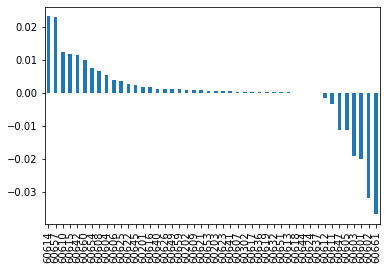

In [ ]:
plot_df['delta'].sort_values(ascending=False).plot(kind='bar')

In [ ]:
G2.number_of_edges()

690

### Density

In [ ]:
from networkx.classes.function import density

In [ ]:
density(G1)

0.6164251207729469

In [ ]:
density(G2)

0.6666666666666666

In [ ]:
density(G3)

0.6164251207729469

In [ ]:
density(G4)

0.6666666666666666